In [1]:
import pandas as pd
import pandas.io.excel
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
%matplotlib inline

In [2]:
mainDir = 'C:/Users/Admin/Documents/xxx/Profession/EnergyProject/EMF/CarbonElasticity'

Here we use no policy as an example to measure price and quantity.

In [3]:
ScenarioName = 'nopolicy'

Our main goal here is to define measurement of quantity and price with consistency. We also want to measure carbon emission in no policy case as well. Hence, we will go over quantity measurement first. Then we will consider no policy case (since there is no price associated with no policy). Finally, we will define price measurment. 

# Quantity measurement

Our main goal here is to measure quantity and price in a same unit. In general, quantity measurement can be divided into fossil fuel (oil, coal, and gas) carbon emission, industry (cement production) carbon emissiion, and land use (deforestation, biomass) carbon emission. 

Our aggregation of interests are (1) CO2 emissinos from fossil fuels only (FOS) (2) CO2 emissions from all sources (TOT). 

The common unit we decide to use is million metric tons of CO2 (MMtCO2).

Note: we no longer need another aggregation: fossil fuels + cement production (FI) and US readings. So we comment those parts out.

## EPPA

Carbon emission in EPPA can be read from $\texttt{result/[scenario name]/v_emit_[scenario name].xls}$. In EPPA, CO2 emissions come from three sources: fossil fuels production in $\texttt{3fos_CO2}$ sheet,  cement production (so called “energy intensive industry production”) in $\texttt{6cem_CO2}$ sheet, and deforestation (so called “agriculture production”)  in $\texttt{7def_CO2}$ sheet. The CO2 emissions from fossil fuels can be read from  $\texttt{3fos_CO2}$ sheet, while total CO2 emissions can be read from $\texttt{5tot_CO2 sheet}$, which is summarized by EPPA.

Note that the output unit in EPPA is million ton of CO2. Since the standard unit in this paper is also million ton of CO2, there is no conversion needed.

Technical note:

To make Python notebook work, that is, to read fossil fuel carbon emission $\texttt{CFOS}$, fossil fuel plus industry carbon emission $\texttt{CFI}$ and total carbon emission $\texttt{CTOT}$ directly and properly, one need to move the original output files to $\texttt{rawresult/EPPA}$ and name them properly.

In EPPA documentation, CO2 sources come from 1) coal, oil, and gas combustion 2) cement production 3) deforestation, biomass burning. Note that unit for tot_co2, fos_co2, and fi_co2 is CO2 ton, while unit for ind_co2 (cement production) and def_co2 (deforestation) is C ton.

In [6]:
filename = 'y_emit_' + ScenarioName + '.xls'
CTOT = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'EPPA' + '/' + ScenarioName +'/' + filename, sheetname="5tot_co2")
CTOT = pd.DataFrame(CTOT.stack()).reset_index()
CTOT.columns = ['region','year','level']
CTOT['level'] = CTOT['level'] #unit conversion to million ton of CO2 (MMtCO2)

#CFI = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'EPPA' + '/'+ ScenarioName +'/'  + filename, sheetname="4fi_co2")
#CFI = pd.DataFrame(CFI.stack()).reset_index()
#CFI.columns = ['region','year','level']
#CFI['level'] = CFI['level'] #unit conversion to million ton of CO2 (MMtCO2)

CFOS = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'EPPA' + '/'+ ScenarioName +'/'  + filename, sheetname="3fos_co2")
CFOS = pd.DataFrame(CFOS.stack()).reset_index()
CFOS.columns = ['region','year','level']
CFOS['level'] = CFOS['level'] #unit conversion to million ton of CO2 (MMtCO2)

In [7]:
#query for USA and sum for global.
#qUS_fos_EPPA = CFOS[CFOS.region=='USA'][['year','level']]
qglobal_fos_EPPA = CFOS[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
#qUS_fi_EPPA = CFI[CFI.region=='USA'][['year','level']]
#qglobal_fi_EPPA = CFI[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
#qUS_tot_EPPA = CTOT[CTOT.region=='USA'][['year','level']]
qglobal_tot_EPPA = CTOT[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()

## GCAM

Carbon emission in GCAM can be read from $\texttt{Main_User_Workspace/output/database.dbxml}$ via JAVA query interface called ModelInterface/Modelnterface.jar. There are two sources of carbon emission: land use change (Query: Land Use > Land Use Change Emission Future) and technologies (Query: CO2 > CO2 emissions by subsector). There are 63 subsectors under carbon emission by technologies, including fossil fuels, biomass, and cement production. 55 of them are potentially derived from fossil fuels. Hence, the CO2 emissions from fossil fuels can be calculated by aggregating CO2 emissions of those 55 subsectors, and total CO2 emissions can be calculated by aggregating CO2 emissions of all 63 subsectors and land use change CO2 emission.

Note that the unit used in GCAM is million ton of carbon. Since the standard unit in this paper is million ton of CO2, we need to convert the values from GCAM by multiplying 44/12.


Technical note: 

To make Python notebook work, we need two export data from two queries above by dragging a bar of query result from Java model interface to an excel spread sheet. Then delete the first row, and save them properly to $\texttt{rawresult/GCAM}$ folder. 

Some subsectors are not clear if they are from fossil fuels or not, so we judge at best of our knowledge.

In [10]:
#Define types of carbon emission in GCAM4.0. If it is not clear, assume it is fossil fuel
FOSlist =[u'3W Rural', u'Bus', u'Compact Car', u'Domestic Aviation', u'Domestic Ship', u'Freight Rail',
 u'Heavy Bus', u'International Aviation',u'International Ship', u'Large Car',u'Large Car and SUV', u'Light Bus',
 u'Light Truck and SUV', u'Midsize Car',u'Mini Car',u'Moped',u'Motorcycle (50-250cc)',u'Motorcycle (>250cc)',
 u'Multipurpose Vehicle', u'Passenger Rail',u'Scooter',u'Subcompact Car',u'Three-Wheeler',u'Truck',u'Truck (0-1t)',
 u'Truck (0-2.7t)',u'Truck (0-2t)',u'Truck (0-3.5t)',u'Truck (0-4.5t)',u'Truck (0-6t)',u'Truck (1-6t)',u'Truck (16-32t)',
 u'Truck (2-5t)',u'Truck (2.7-4.5t)', u'Truck (3.5-16t)', u'Truck (4.5-12t)', u'Truck (4.5-15t)',
 u'Truck (5-9t)', u'Truck (6-14t)', u'Truck (6-15t)', u'Truck (6-30t)', u'Truck (9-16t)', u'Truck (>12t)', u'Truck (>14t)',
    u'Truck (>15t)', u'Truck (>32t)', u'Van',u'coal', u'coal gasification', u'coal to liquids', u'gas', u'gas pipeline',
    u'gas to liquids',u'unconventional oil production',u'oil refining', u'refined liquids']
FIlist = FOSlist + [u'cement']
TOTlist = FIlist + [u'biomass', u'biomass gasification', u'biomass liquids',
 'land-use', u'regional biomass', u'regional biomassOil', u'regional corn for ethanol', u'regional sugar for ethanol']

#Define types of carbon emission as in GCAM3.2
#'''
#FOSlist = [u'LDV', u'air', u'bus', u'coal', u'coal chemical', u'coal gasification', u'coal to liquids', u'domestic ship', u'gas',\
# u'gas chemical', u'gas pipeline', u'gas to liquids', u'international ship', u'oil', u'oil refining', u'rail', u'refined liquids',\
# u'road', u'unconventional oil production']
#FIlist = FOSlist + [u'cement (conv)', u'cement_CCS']
#TOTlist = FIlist + [u'biomass', u'biomass gasification',  u'biomass liquids', u'biomass to H2','land-use',u'regional biomass',\
# u'regional biomassOil', u'regional corn for ethanol', u'regional sugar for ethanol', u'regional sugarbeet for ethanol']
# '''

#Global
#this is for land use change emission
filename = 'global_landuse_' + ScenarioName + '.xlsx'
table1 = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'GCAM/GCAM40_result' + '/'+ ScenarioName +'/'  + filename, sheetname="Sheet1")
table1.drop(['scenario','region','land-use-change-emission','Units',1980,1985,1995,2000],axis=1, inplace=True)
table1['subsector'] = ['land-use']

#this is for other emission
filename = 'global_subsector_' + ScenarioName + '.xlsx'
table2 = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'GCAM/GCAM40_result' + '/'+ ScenarioName +'/'  + filename, sheetname="Sheet1")
table2.drop(['scenario','region','sector','Units'],axis=1, inplace=True)

table = pd.concat([table1,table2])
global_table = table

d =pd.DataFrame(table[table.subsector.map(lambda x: x in FOSlist)].drop(['subsector'],axis=1).sum(axis=0),columns=['level']).reset_index()
d.columns = ['year','level']
d.level = d.level*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)
qglobal_fos_GCAM = d

#d =pd.DataFrame(table[table.subsector.map(lambda x: x in FIlist)].drop(['subsector'],axis=1).sum(axis=0),columns=['level']).reset_index()
#d.columns = ['year','level']
#d.level = d.level*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)
#qglobal_fi_GCAM = d

d =pd.DataFrame(table[table.subsector.map(lambda x: x in TOTlist)].drop(['subsector'],axis=1).sum(axis=0),columns=['level']).reset_index()
d.columns = ['year','level']
d.level = d.level*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)
qglobal_tot_GCAM = d

#US
#this is for land use change emission
#filename = 'us_landuse_' + ScenarioName + '.xlsx'
#table1 = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'GCAM/GCAM40_result' + '/'+ ScenarioName +'/'  + filename, sheetname="Sheet1")
#table1.drop(['scenario','region','land-use-change-emission','Units',1980,1985,1995,2000],axis=1, inplace=True)
#table1['subsector'] = ['land-use']

#this is for other emission
#filename = 'us_subsector_' + ScenarioName + '.xlsx'
#table2 = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'GCAM/GCAM40_result' + '/'+ ScenarioName +'/'  + filename, sheetname="Sheet1")
#table2.drop(['scenario','region','sector','Units'],axis=1, inplace=True)

#table = pd.concat([table1,table2])

#d =pd.DataFrame(table[table.subsector.map(lambda x: x in FOSlist)].drop(['subsector'],axis=1).sum(axis=0),columns=['level']).reset_index()
#d.columns = ['year','level']
#d.level = d.level*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)
#qUS_fos_GCAM = d

#d =pd.DataFrame(table[table.subsector.map(lambda x: x in FIlist)].drop(['subsector'],axis=1).sum(axis=0),columns=['level']).reset_index()
#d.columns = ['year','level']
#d.level = d.level*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)
#qUS_fi_GCAM = d

#d =pd.DataFrame(table[table.subsector.map(lambda x: x in TOTlist)].drop(['subsector'],axis=1).sum(axis=0),columns=['level']).reset_index()
#d.columns = ['year','level']
#d.level = d.level*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)
#qUS_tot_GCAM = d

In [11]:
[len(FOSlist), len(FIlist), len(TOTlist)]

[56, 57, 65]

## MERGE

Carbon emission in MERGE can be read from $\texttt{Merge7/output/[scenario name]_out.gdx}$. In MERGE, variable $\texttt{CLEV}$ contains energy-related carbon emissions which are from both fossil fuels and biomass. On the other hand, $\texttt{CCEM}$ contains non-energy-related carbon emissions which are only from cement production. In MERGE main code $\texttt{Merge7/m7.gms}$, we define a new variable $\texttt{CFOS}$ to represent CO2 emissions from fossil fuels and a new equation $\texttt{cfosdef}$ to assign CO2 emissions from various sources similar to $\text{CLEV}$ excluding non fossil fuels terms. The total CO2 emissions can be calculated by summing $\texttt{CLEV}$ and $\texttt{CCEM}$.

Note that the unit used in MERGE is billion ton of carbon. Since the standard unit in this paper is million ton of CO2, we need to convert the values from GCAM by multiplying 1000*44/12.


Technical note: 

See code modification in modified m7.gms

To make Python notebook work, one need to save each variable in xlsx file, name them properly and move to $\texttt{rawresult/MERGE}$ folder.

In [4]:
#read CLEV
filename = 'CLEV_' + ScenarioName + '.xlsx'
CLEV = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'MERGE' + '/' + ScenarioName +'/' + filename, sheetname="Sheet2")
CLEV.reset_index(inplace = True)
CLEV = CLEV.rename(columns = {'level_0':'year'})
CLEV = CLEV.rename(columns = {'level_1':'region'})
CLEV['Level'] = CLEV['Level']*1000*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)

#read CCEM
filename = 'CCEM_' + ScenarioName + '.xlsx'
CCEM = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'MERGE' + '/' + ScenarioName +'/' + filename, sheetname="Sheet2")
CCEM.reset_index(inplace = True)
CCEM = CCEM.rename(columns = {'level_0':'year'})
CCEM = CCEM.rename(columns = {'level_1':'region'})
CCEM['Level'] = CCEM['Level']*1000*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)

#read CFOS
filename = 'CFOS_' + ScenarioName + '.xlsx'
CFOS = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'MERGE' + '/' + ScenarioName +'/' + filename, sheetname="Sheet2")
CFOS.reset_index(inplace = True)
CFOS = CFOS.rename(columns = {'level_0':'year'})
CFOS = CFOS.rename(columns = {'level_1':'region'})
CFOS['Level'] = CFOS['Level']*1000*44/12 #unit conversion to milliton ton of CO2 (MMtCO2)

#CFOS is computed since 2020
CFI = CCEM[CCEM.columns.values]
CFI = CFI[CFI.year>=2020].reset_index(drop=True)
CFI['Level'] = CFI['Level']+CFOS['Level']

#compute CTOT
CTOT = CLEV[CLEV.columns.values]
CTOT['Level'] = CCEM['Level']+CLEV['Level']

#rename CFOS, CFI, and CTOT
CFOS=CFOS.rename(columns = {'Level':'level'})
CFI=CFI.rename(columns = {'Level':'level'})
CTOT=CTOT.rename(columns = {'Level':'level'})

In [5]:
#query for USA and sum for global.
#qUS_fos_MERGE = CFOS[CFOS.region=='USA'][['year','level']]
qglobal_fos_MERGE = CFOS[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
#qUS_fi_MERGE = CFI[CFI.region=='USA'][['year','level']]
#qglobal_fi_MERGE = CFI[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()
#qUS_tot_MERGE = CTOT[CTOT.region=='USA'][['year','level']]
qglobal_tot_MERGE = CTOT[['year','level']].groupby(['year'])['level'].agg({'level' : lambda x: np.sum(x)}).reset_index()

# No policy case

Here we implicitly define no policy case and run 'nopolicy' case from each model as follow:

$\underline{\text{MERGE}}$: Go to Merge7/studies.xls. Go to sheet 'aero' and mark solve = 1 at ‘aero_bau_bau’ and solve = -1 in all other cases. Then type ‘run aero’ in command prompt in ‘Merge7’ folder.

$\underline{\text{EPPA}}$: Type ‘run v-ref’ in command prompt in ‘active’ folder. This corresponds to using $\texttt{v-ref.cas}$ in active  folder and $\texttt{eppaloop.gms}$. To run other scenarios use 'rrun [filename (don't put '.cas' in)]'. This corresponds to using $\texttt{[filename].cas}$ in active  folder and $\texttt{eppaloop2.gms}$.

$\underline{\text{GCAM}}$: Add nothing. Just check if ‘configuration.xml’ in exe folder has desired input files via Notepad++. Then run by double-clicking “Objects-MI.exe”


We may run quantity measurement for 'nopolicy' from each model, save data in formats and names as explained above, and get following quantity comparison.

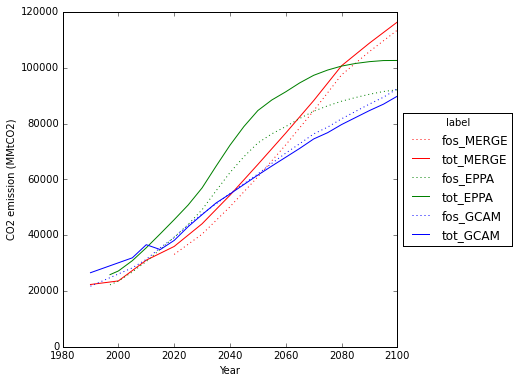

In [15]:
fig = plt.figure(figsize=(6,6))
#fig = plt.figure(figsize=(6,12))
ax1  = fig.add_subplot(111)
#ax1  = fig.add_subplot(211)
ax1.plot(qglobal_fos_MERGE.year,qglobal_fos_MERGE.level,color='red', linestyle = ':',label = 'fos_MERGE')
#ax1.plot(qglobal_fi_MERGE.year,qglobal_fi_MERGE.level,color='red', linestyle = '--', label = 'fi_MERGE')
ax1.plot(qglobal_tot_MERGE.year,qglobal_tot_MERGE.level,color='red', linestyle = '-',label = 'tot_MERGE')
ax1.plot(qglobal_fos_EPPA.year,qglobal_fos_EPPA.level,color='green', linestyle = ':', label = 'fos_EPPA')
#ax1.plot(qglobal_fi_EPPA.year,qglobal_fi_EPPA.level,color='green', linestyle = '--', label = 'fi_EPPA')
ax1.plot(qglobal_tot_EPPA.year,qglobal_tot_EPPA.level,color='green', linestyle = '-', label = 'tot_EPPA')
ax1.plot(qglobal_fos_GCAM.year,qglobal_fos_GCAM.level,color='blue', linestyle = ':', label = 'fos_GCAM')
#ax1.plot(qglobal_fi_GCAM.year,qglobal_fi_GCAM.level,color='blue', linestyle = '--', label = 'fi_GCAM')
ax1.plot(qglobal_tot_GCAM.year,qglobal_tot_GCAM.level,color='blue', linestyle = '-', label = 'tot_GCAM')
ax1.set_xlabel('Year')
ax1.set_ylabel('CO2 emission (MMtCO2)')
ax1.set_ylim(0,120000)
#ax1.set_title('No policy: global')

ax1.legend()
from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5),title='label')

fig.show()


In [1]:
#fig = plt.figure(figsize=(6,6))
#fig = plt.figure(figsize=(6,12))
#ax1  = fig.add_subplot(111)
#ax1  = fig.add_subplot(212)
#ax1.plot(qUS_fos_MERGE.year,qUS_fos_MERGE.level,color='red', linestyle = ':',label = 'fos_MERGE')
#ax1.plot(qUS_fi_MERGE.year,qUS_fi_MERGE.level,color='red', linestyle = '--', label = 'fi_MERGE')
#ax1.plot(qUS_tot_MERGE.year,qUS_tot_MERGE.level,color='red', linestyle = '-',label = 'tot_MERGE')
#ax1.plot(qUS_fos_EPPA.year,qUS_fos_EPPA.level,color='green', linestyle = ':', label = 'fos_EPPA')
#ax1.plot(qUS_fi_EPPA.year,qUS_fi_EPPA.level,color='green', linestyle = '--', label = 'fi_EPPA')
#ax1.plot(qUS_tot_EPPA.year,qUS_tot_EPPA.level,color='green', linestyle = '-', label = 'tot_EPPA')
#ax1.plot(qUS_fos_GCAM.year,qUS_fos_GCAM.level,color='blue', linestyle = ':', label = 'fos_GCAM')
#ax1.plot(qUS_fi_GCAM.year,qUS_fi_GCAM.level,color='blue', linestyle = '--', label = 'fi_GCAM')
#ax1.plot(qUS_tot_GCAM.year,qUS_tot_GCAM.level,color='blue', linestyle = '-', label = 'tot_GCAM')
#ax1.set_ylabel('CO2 emission (MMtCO2)')
#ax1.set_title('No policy: US')
#ax1.set_ylim(0,14000)

#ax1.legend()
#from collections import OrderedDict
#handles, labels = plt.gca().get_legend_handles_labels()
#by_label = OrderedDict(zip(labels, handles))
#ax1.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5),title='label')

#fig.show()

# Price measurement

To match the unit of quantity (MMtCO2), price measureent should be in 2005 dollars per ton CO2. Here we use inflation rate as in Wilkerson et al. 2015.

Note: there is no price measurement in no policy case.

## EPPA

CO2 price in EPPA can be read a sheet named $\texttt{9c_price}$ in a spreadsheet  $\texttt{result/[scenario name]/v_res_[scenario name].xls}$. This is applicable to both price-based and policy-based policies. Note that in price-based policy, the value from the query should be equal to assigned CO2 tax.

Note that the unit used in EPPA is 1997 dollars/ton of CO2. Since the standard unit in this paper is 2005 dollars/ton of CO2, we need to convert the values from EPPA by multiplying 1/0.84628, where 0.84628 is deflation factor from Wilkerson et al. 2015.

Technical detail:
    
To make Python notebook work, one needs to move the original output file and name them properly to $\texttt{rawresult/EPPA}$ folder.

Since EPPA allows trading by default, price should be equal for all regions.

In [24]:
'''
filename = 'y_res_' + ScenarioName + '.xls'
cbtax = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'EPPA' + '/'+ ScenarioName +'/'  + filename, sheetname="9c_price")
cbtax = pd.DataFrame(cbtax.stack()).reset_index()
cbtax.columns = ['region','year','price']
cbtax['price'] = cbtax['price']/0.84628

p_EPPA = cbtax[(cbtax.region=='USA')][['year','price']]
'''
[0]

[0]

## GCAM

CO2 price in GCAM can be read easily from $\texttt{Main_User_Workspace/output/database.dbxml}$ via JAVA query interface called $\texttt{ModelInterface/Modelnterface.jar}$ with query: CO2 > CO2 prices. This is applicable to both price-based and policy-based policies. Note that in price-based policy, the value from the query should be equal to assigned CO2 tax.

Note that the output unit in GCAM is 1990 dollars/ton of carbon. Since the standard unit in this paper is 2005 dollars/ton of CO2, we need to convert the values from GCAM by multiplying (12/44)/0.72262, where 0.72262 is deflation factor from Wilkerson et al. 2015.


Technical note: 

To make Python notebook work, we need two export data from a query above by dragging a bar of query result from Java model interface to an excel spread sheet. Then delete the first row, and save them properly to $\texttt{rawresult/GCAM}$ folder. 

Since GCAM allows trading by default, price should be equal for all regions. 

In [2]:
'''
filename = 'co2price_' + ScenarioName + '.xlsx'
co2price = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'GCAM' + '/' + ScenarioName +'/' + filename, sheetname="Sheet1")

co2price.drop(['scenario','market','Units'],axis=1,inplace=True)
co2price.set_index('region',inplace=True)
co2price = pd.DataFrame(co2price.stack()).reset_index()
co2price.columns = ['region','year','price']
co2price['price'] = co2price['price']*12/44/0.72262 #unit conversion to 2005 dollars per CO2 ton

co2price[co2price.region=='Global'][['year','price']]
'''
[0]

[0]

## MERGE

CO2 price in MERGE can be read from a variable  $\texttt{dual(pp, rg, “carbon”)}$ in  $\texttt{Merge7/output/[scenario name]_out.gdx.}$ In price-based policy, the value from the query should be equal to assigned CO2 tax. In quantity-based policy, the value comes from finding dual variable of CO2 emissions constraint.

Note that the output unit in MERGE is 1990 dollars/ton of carbon. Since the standard unit in this paper is 2005 dollars/ton of CO2, we need to convert the values from MERGE by multiplying (12/44)/0.72262, where 0.72262 is deflation factor from Wilkerson et al. 2015.


Technical note: 

To make Python notebook work, one need to save the variable in xlsx file, name them properly and move to $\texttt{rawresult/MERGE}$ folder.

Since MERGE allows trading by default, price should be equal to all regions.

In [23]:
'''
filename = 'dual_' + ScenarioName + '.xlsx'
dual = pandas.io.excel.read_excel(mainDir + '/rawresult/' + 'MERGE' + '/' + ScenarioName +'/' + filename, sheetname="Sheet2", header = None)
dual.columns = ['year','region','type','price']
def Conversion(x):
    if x=='Eps':
        x = float('NaN')
    else:
        x = float(x)*12/44/0.88723
    return x;
dual['price'] = dual['price'].map(lambda x: Conversion(x))

p_MERGE = dual[(dual.region=='USA')&(dual.type=='carbon')][['year','price']]
'''
[0]

[0]